# Analysis of `owsee` sample output

## Introduction

This notebook does some sanity checks on "`opsim4`" style databases produced by `owsee` as follows:

```bash
python owsee.py seeing.db baseline2018a.db nullop_baseline2018a.db --verbose
python owsee.py simsee_pachon7.db baseline2018a.db ow_baseline2018a.db --verbose
python owsee.py simsee_pachon7.db baseline2018a.db owc_baseline2018a.db --apply_clouds --verbose
```

`simee_pachen7.db` was produced by `simsee`. A copy can be found on `cori.nersc.gov` at `/global/project/projectdirs/lsst/survey_sims/input/seeing/simsee_pachon7.db`.

`baseline2018a.db` was retrieved from this page: `http://astro-lsst-01.astro.washington.edu:8080/`.

`seeing.db` is the seeing database from `/home/opsim/repos/sims_seeingModel/data/seeing.db` in the `opsim4_fbs_py3-opsim4.1.3` container.


## Juypter boilerplate

### Basic notebook configuration

In [1]:
%matplotlib inline
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

### Base python modules

In [2]:
import sys
import os

### Standard scientific python stuff

In [70]:
import numpy as np
import pandas as pd
import scipy
import scipy.stats
import matplotlib as mpl
import matplotlib.pyplot as plt
import healpy
import sqlite3

### Set plotting style

In [4]:
mpl.rcParams['figure.figsize'] = (10, 5)
plt.style.use('ggplot')

### LSST specific modules

In [5]:
import lsst.sims.maf
import lsst.sims.maf.db as db
import lsst.sims.maf.metrics as metrics
import lsst.sims.maf.slicers as slicers
import lsst.sims.maf.stackers as stackers
import lsst.sims.maf.plots as plots
import lsst.sims.maf.metricBundles as metricBundles

lsst.sims.maf.__version__

'2.8.0.sims-1-g3e1d601'

## Configuration

In [7]:
sim_db_path = '/data/des70.a/data/neilsen/obs_strat/code/simsee/tmp'
base_results_path = '/data/des70.a/data/neilsen/obs_strat/code/simsee/tmp'

## Compare seeing histories of the new and default simulations

### Supporting code

Create a "year stacker" so I can use it to plot the seeing history with a scale of years:

In [11]:
class YearStacker(stackers.BaseStacker):
    """Calculate the floating point years into the survey."""
    def __init__(self, mjd_col='observationStartMJD'):
        self.colsAdded = ['years_into_survey']
        self.colsReq = [mjd_col]
        self.units = ['years']
        self.mjd_col = mjd_col
        
    def _run(self, simData, cols_present=False):
        """Calculate new column years into the survey."""
        if cols_present:
            # Column already present in data; assume it is correct and does not need recalculating.
            return simData
        simData['years_into_survey'] = (simData[self.mjd_col].astype(float) - 59580)/365.24
        return simData

Create a procedure for plotting the seeing with time:

In [12]:
def plot_seeing_vs_year(dbname):
    sim_db_name = os.path.join(sim_db_path, dbname) + os.extsep + 'db'
    sim_db = db.OpsimDatabase(sim_db_name)
    
    results_path = os.path.join(base_results_path, dbname)
    results_db = db.ResultsDb(outDir=results_path)

    seeing_metric = metrics.MeanMetric('seeingFwhm500')
    year_slicer = slicers.OneDSlicer('years_into_survey', 'years', 12*10)
    mean_seeing = metricBundles.MetricBundle(seeing_metric, year_slicer, stackerList=[YearStacker()])
    mean_seeing_bundle = {'mean_seeing': mean_seeing}
    mean_seeing_group = metricBundles.MetricBundleGroup(mean_seeing_bundle, sim_db, outDir=results_path, resultsDb=results_db)
    
    mean_seeing_group.runAll()
    
    mean_seeing_group.plotAll(closefigs=False)

### Base simulation seeing history

Querying database SummaryAllProps with no constraint for columns ['observationStartMJD', 'seeingFwhm500'].
Found 2372700 visits
Running:  ['mean_seeing']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Plotting figures with "" constraint now.
Plotting complete.


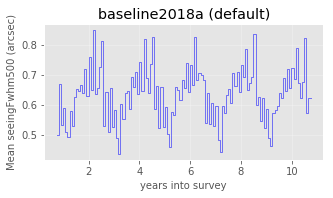

In [13]:
mpl.rcParams['figure.figsize'] = (5, 2.5)
plot_seeing_vs_year('baseline2018a')
plt.xlabel('years into survey')
plt.title('baseline2018a (default)')

### Check `nullop` against baseline

Querying database SummaryAllProps with no constraint for columns ['observationStartMJD', 'seeingFwhm500'].
Found 2372700 visits
Running:  ['mean_seeing']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Plotting figures with "" constraint now.
Plotting complete.


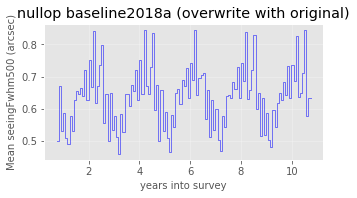

In [59]:
mpl.rcParams['figure.figsize'] = (5, 2.5)
plot_seeing_vs_year('nullop_baseline2018a')
plt.xlabel('years into survey')
plt.title('nullop baseline2018a (overwrite with original)')

This is close, but not identical -- the results are close enough to the original that the difference isn't scientifically significant, but that there is a difference at all is mysterious.

Why was `nullop` not really a null op?

In [74]:
baseline_db_fname = os.path.join(sim_db_path, 'baseline2018a.db')
nullop_db_fname = os.path.join(sim_db_path, 'nullop_baseline2018a.db')

with sqlite3.connect(baseline_db_fname) as conn:
    baseline = pd.read_sql('SELECT * FROM SummaryAllProps', conn)
    
with sqlite3.connect(nullop_db_fname) as conn:
    nullop = pd.read_sql('SELECT * FROM SummaryAllProps', conn)

In [80]:
nullop['orig_seeingFwhm500'] = baseline.seeingFwhm500

In [81]:
df = nullop.loc[:, ['observationId', 'seeingFwhm500', 'orig_seeingFwhm500']]

In [86]:
df.head(30)

,observationId,seeingFwhm500,orig_seeingFwhm500
0,1,0.550229,0.510839
1,2,0.510839,0.510839
2,3,0.510839,0.518348
3,4,0.510839,0.518348
4,5,0.510839,0.518348
5,6,0.518348,0.518348
6,7,0.518348,0.518348
7,8,0.518348,0.518348
8,9,0.518348,0.524457
9,10,0.524457,0.524457


Okay, it looks like the exposure start times the simulations in the seeing database get mapped to in the sim are shifted by a few minutes between the `owsee` code and the `OpSim` code. This is annoying, but scientifically it shouldn't matter.

Let's test that the depth and other forms of seeing are the same when the times line up well enough that they have the same seeing from the database.

In [93]:
baseline.set_index('observationId').loc[12, ['seeingFwhm500', 'seeingFwhmGeom', 'seeingFwhmEff', 'fiveSigmaDepth']]

seeingFwhm500     0.524457
seeingFwhmGeom    0.633024
seeingFwhmEff     0.706842
fiveSigmaDepth     23.3238
Name: 12, dtype: object

In [94]:
nullop.set_index('observationId').loc[12, ['seeingFwhm500', 'seeingFwhmGeom', 'seeingFwhmEff', 'fiveSigmaDepth']]

seeingFwhm500     0.524457
seeingFwhmGeom    0.633025
seeingFwhmEff     0.706843
fiveSigmaDepth     23.3238
Name: 12, dtype: object

Okay, so it does look like the calculated columns are identical.

### Simulation with remodeled seeing

Querying database SummaryAllProps with no constraint for columns ['observationStartMJD', 'seeingFwhm500'].
Found 2372700 visits
Running:  ['mean_seeing']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Plotting figures with "" constraint now.
Plotting complete.


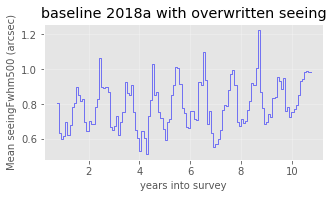

In [16]:
plot_seeing_vs_year('ow_baseline2018a')
plt.xlabel('years into survey')
plt.title('baseline 2018a with overwritten seeing')

Querying database SummaryAllProps with no constraint for columns ['observationStartMJD', 'seeingFwhm500'].
Found 2372700 visits
Running:  ['mean_seeing']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Plotting figures with "" constraint now.
Plotting complete.


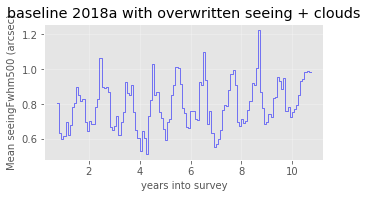

In [17]:
plot_seeing_vs_year('owc_baseline2018a')
plt.xlabel('years into survey')
plt.title('baseline 2018a with overwritten seeing + clouds')

## Map the seeing in the different simulations

### Supporting code

#### Hacked version of HealpixSkyMap that allows specification of the color limits

The structure of the class doesn't lend itself to modification through subclassing, so I need to just copy most of the code.

In [18]:
class HealpixSkyMap(plots.spatialPlotters.BasePlotter):
    """
    Generate a sky map of healpix metric values using healpy's mollweide view.
    """
    def __init__(self, clims=None):
        super(HealpixSkyMap, self).__init__()
        # Set the plotType
        self.clims = clims
        self.plotType = 'SkyMap'
        self.objectPlotter = False
        # Set up the default plotting parameters.
        self.defaultPlotDict = {}
        self.defaultPlotDict.update(plots.spatialPlotters.baseDefaultPlotDict)
        self.defaultPlotDict.update({'rot': (0, 0, 0), 'coord': 'C'})

    def __call__(self, metricValueIn, slicer, userPlotDict, fignum=None):
        """
        Parameters
        ----------
        metricValue : numpy.ma.MaskedArray
        slicer : lsst.sims.maf.slicers.HealpixSlicer
        userPlotDict: dict
            Dictionary of plot parameters set by user (overrides default values).
        fignum : int
            Matplotlib figure number to use (default = None, starts new figure).

        Returns
        -------
        int
           Matplotlib figure number used to create the plot.
        """
        # Override the default plotting parameters with user specified values.
        plotDict = {}
        plotDict.update(self.defaultPlotDict)
        plotDict.update(userPlotDict)
        # Update the metric data with zeropoint or normalization.
        metricValue = plots.spatialPlotters.applyZPNorm(metricValueIn, plotDict)
        # Generate a Mollweide full-sky plot.
        fig = plt.figure(fignum, figsize=plotDict['figsize'])
        # Set up color bar limits.
        clims = plots.spatialPlotters.setColorLims(metricValue, plotDict) if self.clims is None else self.clims
        cmap = plots.spatialPlotters.setColorMap(plotDict)
        # Set log scale?
        norm = None
        if plotDict['logScale']:
            norm = 'log'
        # Avoid trying to log scale when zero is in the range.
        if (norm == 'log') & ((clims[0] <= 0 <= clims[1]) or (clims[0] >= 0 >= clims[1])):
            # Try something simple
            above = metricValue[np.where(metricValue > 0)]
            if len(above) > 0:
                clims[0] = above.max()
            # If still bad, give up and turn off norm
            if ((clims[0] <= 0 <= clims[1]) or (clims[0] >= 0 >= clims[1])):
                norm = None
            plots.spatialPlotters.warnings.warn("Using norm was set to log, but color limits pass through 0. "
                          "Adjusting so plotting doesn't fail")

        plots.spatialPlotters.hp.mollview(metricValue.filled(slicer.badval), title=plotDict['title'], cbar=False,
                    min=clims[0], max=clims[1], rot=plotDict['rot'], flip='astro',
                    coord=plotDict['coord'], cmap=cmap, norm=norm,
                    sub=plotDict['subplot'], fig=fig.number)
        # Add a graticule (grid) over the globe.
        plots.spatialPlotters.hp.graticule(dpar=30, dmer=30, verbose=False)
        # Add colorbar (not using healpy default colorbar because we want more tickmarks).
        ax = plt.gca()
        im = ax.get_images()[0]
        # Add label.
        if plotDict['label'] is not None:
            plt.figtext(0.8, 0.8, '%s' % (plotDict['label']))
        # Make a color bar. Supress silly colorbar warnings.
        with plots.spatialPlotters.warnings.catch_warnings():
            plots.spatialPlotters.warnings.simplefilter("ignore")
            cb = plt.colorbar(im, shrink=0.75, aspect=25, pad=0.1, orientation='horizontal',
                              format=plotDict['cbarFormat'], extendrect=True)
            cb.set_label(plotDict['xlabel'], fontsize=plotDict['fontsize'])
            if plotDict['labelsize'] is not None:
                cb.ax.tick_params(labelsize=plotDict['labelsize'])
            if norm == 'log':
                tick_locator = plots.spatialPlotters.ticker.LogLocator(numticks=plotDict['nTicks'])
                cb.locator = tick_locator
                cb.update_ticks()
            if (plotDict['nTicks'] is not None) & (norm != 'log'):
                tick_locator = plots.spatialPlotters.ticker.MaxNLocator(nbins=plotDict['nTicks'])
                cb.locator = tick_locator
                cb.update_ticks()
        # If outputing to PDF, this fixes the colorbar white stripes
        if plotDict['cbar_edge']:
            cb.solids.set_edgecolor("face")
        return fig.number


#### Function to do the plot itself

In [19]:
def map_seeing(dbname,
              sql_constraint = 'filter = "i" AND proposalId=3',
              metric=metrics.MeanMetric,
             ):
    sim_db_name = os.path.join(sim_db_path, dbname) + os.extsep + 'db'
    sim_db = db.OpsimDatabase(sim_db_name)
    
    results_path = os.path.join(base_results_path, dbname)
    results_db = db.ResultsDb(outDir=results_path)

    depth_metric = metric('seeingFwhmEff')
    healpix_slicer = slicers.HealpixSlicer(nside=64)
    metric_bundle = {'seeingFwhmEff': metricBundles.MetricBundle(depth_metric, healpix_slicer, sql_constraint)}
    metric_group = metricBundles.MetricBundleGroup(metric_bundle, sim_db, outDir=results_path, resultsDb=results_db)
    
    metric_group.runAll()
    
    df = pd.DataFrame.from_records(metric_group.simData)
    print(df.seeingFwhmEff.describe())
    
    metric_group.bundleDict['seeingFwhmEff'].setPlotFuncs([HealpixSkyMap(clims=[0.75,1.2])])
    metric_group.plotAll(closefigs=False)

### Base simulation FWHM map

Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Querying database SummaryAllProps with constraint filter = "i" AND proposalId=3 for columns ['fieldDec', 'fieldRA', 'seeingFwhmEff']
Found 444867 visits
Running:  ['seeingFwhmEff']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
count    444867.000000
mean          0.855858
std           0.183121
min           0.484715
25%           0.725812
50%           0.825945
75%           0.955705
max           1.970432
Name: seeingFwhmEff, dtype: float64
Plotting figures with "filter = "i" AND proposalId=3" constraint now.
Plotting complete.


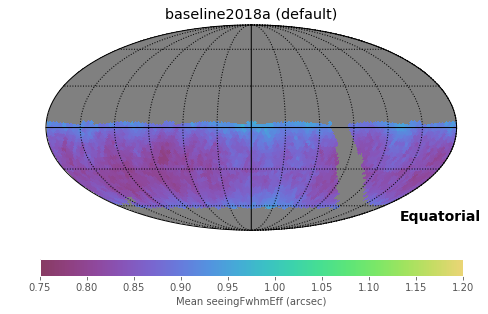

In [20]:
mpl.rcParams['figure.figsize'] = (8, 4)
map_seeing('baseline2018a')
plt.title('baseline2018a (default)')

Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Querying database SummaryAllProps with constraint filter = "i" AND proposalId=3 for columns ['fieldDec', 'fieldRA', 'seeingFwhmEff']
Found 444867 visits
Running:  ['seeingFwhmEff']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
count    444867.000000
mean          0.856941
std           0.187078
min           0.483036
25%           0.724736
50%           0.825401
75%           0.955342
max           2.673079
Name: seeingFwhmEff, dtype: float64
Plotting figures with "filter = "i" AND proposalId=3" constraint now.
Plotting complete.


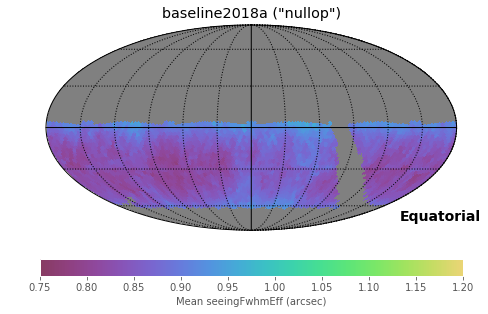

In [67]:
mpl.rcParams['figure.figsize'] = (8, 4)
map_seeing('nullop_baseline2018a')
plt.title('baseline2018a ("nullop")')

### Remodeled seeing FWHM map

Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Querying database SummaryAllProps with constraint filter = "i" AND proposalId=3 for columns ['fieldDec', 'fieldRA', 'seeingFwhmEff']
Found 444867 visits
Running:  ['seeingFwhmEff']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
count    444867.000000
mean          1.011687
std           0.324188
min           0.465328
25%           0.786081
50%           0.937381
75%           1.154988
max           4.263598
Name: seeingFwhmEff, dtype: float64
Plotting figures with "filter = "i" AND proposalId=3" constraint now.
Plotting complete.


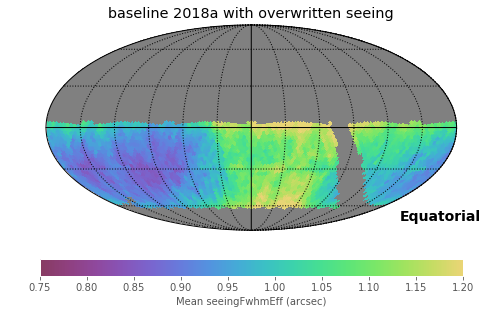

In [21]:
map_seeing('ow_baseline2018a')
plt.title('baseline 2018a with overwritten seeing')

## Compare the depths of the different simulations

### Supporting code

In [22]:
def map_depth(dbname,
              sql_constraint = 'filter = "i" AND proposalId=3',
              metric=metrics.MeanMetric,
             ):
    sim_db_name = os.path.join(sim_db_path, dbname) + os.extsep + 'db'
    sim_db = db.OpsimDatabase(sim_db_name)
    
    results_path = os.path.join(base_results_path, dbname)
    results_db = db.ResultsDb(outDir=results_path)

    depth_metric = metric('fiveSigmaDepth')
    healpix_slicer = slicers.HealpixSlicer(nside=64)
    metric_bundle = {'depth': metricBundles.MetricBundle(depth_metric, healpix_slicer, sql_constraint)}
    metric_group = metricBundles.MetricBundleGroup(metric_bundle, sim_db, outDir=results_path, resultsDb=results_db)
    
    metric_group.runAll()

    df = pd.DataFrame.from_records(metric_group.simData)
    print(df.fiveSigmaDepth.describe())

    metric_group.bundleDict['depth'].setPlotFuncs([HealpixSkyMap(clims=[23.2,23.85])])
    metric_group.plotAll(closefigs=False)

### Base simulation depth map

Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Querying database SummaryAllProps with constraint filter = "i" AND proposalId=3 for columns ['fieldDec', 'fiveSigmaDepth', 'fieldRA']
Found 444867 visits
Running:  ['depth']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
count    444867.000000
mean         23.670439
std           0.260178
min          22.444138
25%          23.501279
50%          23.685480
75%          23.855085
max          24.390311
Name: fiveSigmaDepth, dtype: float64
Plotting figures with "filter = "i" AND proposalId=3" constraint now.
Plotting complete.


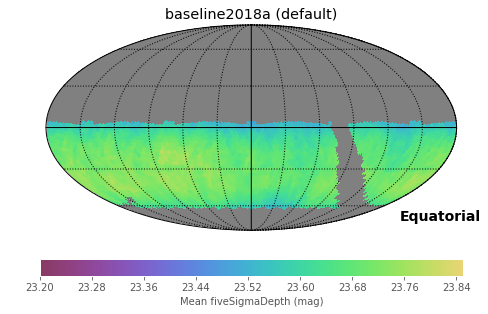

In [23]:
map_depth('baseline2018a')
plt.title('baseline2018a (default)')

### Remodeled seeing depth map

Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Querying database SummaryAllProps with constraint filter = "i" AND proposalId=3 for columns ['fieldDec', 'fiveSigmaDepth', 'fieldRA']
Found 444867 visits
Running:  ['depth']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
count    444867.000000
mean         23.512360
std           0.339526
min          21.734174
25%          23.295903
50%          23.542134
75%          23.760152
max          24.440478
Name: fiveSigmaDepth, dtype: float64
Plotting figures with "filter = "i" AND proposalId=3" constraint now.
Plotting complete.


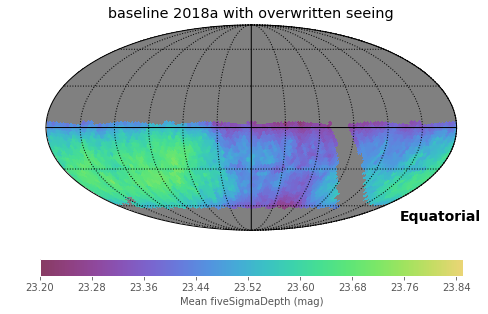

In [25]:
map_depth('ow_baseline2018a')
plt.title('baseline 2018a with overwritten seeing')

Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Querying database SummaryAllProps with constraint filter = "i" AND proposalId=3 for columns ['fieldDec', 'fiveSigmaDepth', 'fieldRA']
Found 444867 visits
Running:  ['depth']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
count    444867.000000
mean         23.409898
std           0.397502
min          13.104455
25%          23.161935
50%          23.449424
75%          23.703589
max          24.440478
Name: fiveSigmaDepth, dtype: float64
Plotting figures with "filter = "i" AND proposalId=3" constraint now.
Plotting complete.


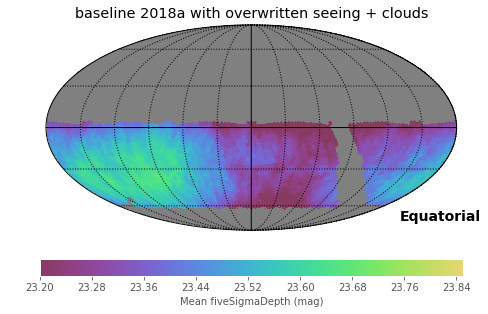

In [26]:
map_depth('owc_baseline2018a')
plt.title('baseline 2018a with overwritten seeing + clouds')

## Plotting depth and seeing with field R.A.

### Support code

Load data into `pandas.DataFrame`s.

In [27]:
def load_df(dbname,
            metric_columns = ['seeingFwhmEff', 'fiveSigmaDepth'],
            slice_column = 'fieldRA',
            sql_constraint = 'filter = "i" AND proposalId=3',
            agg_metric=metrics.MeanMetric):
    sim_db_name = os.path.join(sim_db_path, dbname) + os.extsep + 'db'
    sim_db = db.OpsimDatabase(sim_db_name)
    
    results_path = os.path.join(base_results_path, dbname)
    results_db = db.ResultsDb(outDir=results_path)

    slicer_for_df = slicers.OneDSlicer(slice_column)
    metric_bundle = {col: metricBundles.MetricBundle(agg_metric(col), slicer_for_df, sql_constraint)
                     for col in metric_columns}
    metric_group = metricBundles.MetricBundleGroup(metric_bundle, sim_db, outDir=results_path, resultsDb=results_db)
    metric_group.runAll()
    df = pd.DataFrame.from_records(metric_group.simData)
    df.sort_values('fieldRA', inplace=True)
    df['hour'] = np.floor(df.fieldRA/15).astype(np.int32)
    return df

### Load the data

In [60]:
see_by_ra = {1: load_df('baseline2018a'),
             2: load_df('ow_baseline2018a'),
             3: load_df('owc_baseline2018a'),
             4: load_df('nullop_baseline2018a')}

Querying database SummaryAllProps with constraint filter = "i" AND proposalId=3 for columns ['fiveSigmaDepth', 'fieldRA', 'seeingFwhmEff']
Found 444867 visits
Running:  ['seeingFwhmEff']
Completed metric generation.
Running:  ['fiveSigmaDepth']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.


/home/docmaf/repos/sims_maf/python/lsst/sims/maf/slicers/oneDSlicer.py:74: UserWarning: Both binsize and bins have been set; Using binsize 4.716788 only.
  warnings.warn('Both binsize and bins have been set; Using binsize %f only.' %(self.binsize))


Querying database SummaryAllProps with constraint filter = "i" AND proposalId=3 for columns ['fiveSigmaDepth', 'fieldRA', 'seeingFwhmEff']
Found 444867 visits
Running:  ['seeingFwhmEff']
Completed metric generation.
Running:  ['fiveSigmaDepth']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint filter = "i" AND proposalId=3 for columns ['fiveSigmaDepth', 'fieldRA', 'seeingFwhmEff']
Found 444867 visits
Running:  ['seeingFwhmEff']
Completed metric generation.
Running:  ['fiveSigmaDepth']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint filter = "i" AND proposalId=3 for columns ['fiveSigmaDepth', 'fieldRA', 'seeingFwhmEff']
Found 444867 visits
Running:  ['seeingFwhmEff']
Completed metric generation.
Running:  ['fiveSigmaDepth']
Completed metric generation.
Running reduce methods.
Running summary statistics.


In [64]:
(see_by_ra[1].seeingFwhmEff - see_by_ra[4].seeingFwhmEff).describe()

count    444867.000000
mean         -0.001083
std           0.193702
min          -1.414791
25%          -0.104877
50%           0.000021
75%           0.105507
max           1.022708
Name: seeingFwhmEff, dtype: float64

In [63]:
(see_by_ra[1].fiveSigmaDepth - see_by_ra[4].fiveSigmaDepth).describe()

count    444867.000000
mean          0.000701
std           0.226209
min          -0.970635
25%          -0.138937
50%          -0.000027
75%           0.138627
max           1.015202
Name: fiveSigmaDepth, dtype: float64

### Plot depth against R.A.

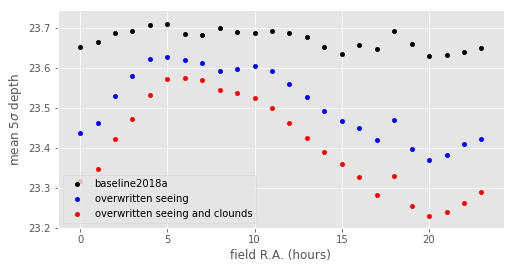

In [38]:
fig, axes = plt.subplots()
legend_label = {1: 'baseline2018a', 2: 'overwritten seeing', 3: 'overwritten seeing and clounds'}
point_color = {1: 'k', 2: 'b', 3: 'r'}
for idx in (1, 2, 3):
    df = see_by_ra[idx]
    label = legend_label[idx]
    color = point_color[idx]
    df.groupby(df.hour).mean().reset_index().plot.scatter('hour', 'fiveSigmaDepth', c=color, label=label, ax=axes)
axes.set_xlabel('field R.A. (hours)')
axes.set_ylabel('mean 5$\sigma$ depth')

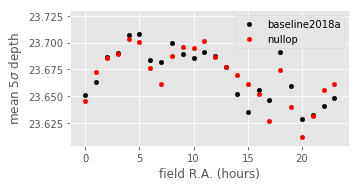

In [65]:
fig, axes = plt.subplots()
legend_label = {1: 'baseline2018a', 4: 'nullop'}
point_color = {1: 'k', 4: 'r'}
for idx in (1, 4):
    df = see_by_ra[idx]
    label = legend_label[idx]
    color = point_color[idx]
    df.groupby(df.hour).mean().reset_index().plot.scatter('hour', 'fiveSigmaDepth', c=color, label=label, ax=axes)
axes.set_xlabel('field R.A. (hours)')
axes.set_ylabel('mean 5$\sigma$ depth')

Again, the one intended to be a nullop is only almost a nullop.

What is the difference between the base and the revisions?

In [32]:
print("Difference between base and overwritten seeing: ",
     np.round(see_by_ra[1].fiveSigmaDepth.mean()-see_by_ra[2].fiveSigmaDepth.mean(), 2))
print("Difference between base and overwritren seeing + clouds: ",
     np.round(see_by_ra[1].fiveSigmaDepth.mean()-see_by_ra[3].fiveSigmaDepth.mean(), 2))

Difference between base and overwritten seeing:  0.16
Difference between base and overwritren seeing + clouds:  0.26


What's the difference between the worst and best sets of months?

In [33]:
print('Difference in baseline2018a: ', np.round(see_by_ra[1].query('4 <= hour <= 9').fiveSigmaDepth.mean() - see_by_ra[1].query('16 <= hour <= 21').fiveSigmaDepth.mean(), 2))
print('Difference in overwritten seeing: ', np.round(see_by_ra[2].query('4 <= hour <= 9').fiveSigmaDepth.mean() - see_by_ra[2].query('16 <= hour <= 21').fiveSigmaDepth.mean(), 2))
print('Difference in overwritten seeing and clounds: ', np.round(see_by_ra[3].query('4 <= hour <= 9').fiveSigmaDepth.mean() - see_by_ra[3].query('16 <= hour <= 21').fiveSigmaDepth.mean(), 2))

Difference in baseline2018a:  0.05
Difference in overwritten seeing:  0.21
Difference in overwritten seeing and clounds:  0.29


What are these in decimal degrees?

In [35]:
np.array([4, 9+1, 16, 21+1])*15

array([ 60, 150, 240, 330])

### Plot delivered FWHM against R.A.

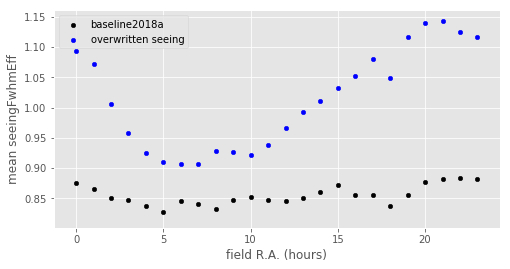

In [36]:
fig, axes = plt.subplots()
legend_label = {1: 'baseline2018a', 2: 'overwritten seeing', 3: 'overwritten seeing and clounds'}
point_color = {1: 'k', 2: 'b', 3: 'r'}
for idx in (1, 2):
    df = see_by_ra[idx]
    label = legend_label[idx]
    color = point_color[idx]
    df.groupby(df.hour).mean().reset_index().plot.scatter('hour', 'seeingFwhmEff', c=color, label=label, ax=axes)
axes.set_xlabel('field R.A. (hours)')
axes.set_ylabel('mean seeingFwhmEff')

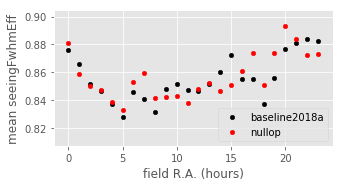

In [66]:
fig, axes = plt.subplots()
legend_label = {1: 'baseline2018a', 4: 'nullop'}
point_color = {1: 'k', 4: 'r'}
for idx in (1, 4):
    df = see_by_ra[idx]
    label = legend_label[idx]
    color = point_color[idx]
    df.groupby(df.hour).mean().reset_index().plot.scatter('hour', 'seeingFwhmEff', c=color, label=label, ax=axes)
axes.set_xlabel('field R.A. (hours)')
axes.set_ylabel('mean seeingFwhmEff')